# M2DS, Machine learning for signal processing (MLSP) <br> Lab 1. ADMM & PnP-ADMM: application to compressed sensing

# Setup

Detailed setup instructions are contained in the [README](README.md) file provided with the lab archive.

In [1]:
from os.path import basename, join, realpath, splitext
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from skimage.metrics import structural_similarity as ssim

import mlsp.utils.lab_utils as utls

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

%load_ext autoreload
%autoreload 2

# Model and data generation

This lab is devoted to the resolution to an imaging compressed-sensing problem. The asociated measurement model is given by

\begin{equation}
    \mathbf{y} = \mathbf{Ax} + \boldsymbol{\varepsilon}, \quad \boldsymbol{\varepsilon} \sim \mathcal{N}(0, \sigma^2 \mathbf{I}_{M \times M}),
\end{equation}

where $\mathbf{y} \in \mathbb{C}^M$ are the measurements, $\mathbf{A} \in \mathbb{C}^{M \times N}$ is a known linear compressed sensing operator, $\sigma^2$ is the noise variance, $\mathbf{x} \in \mathbb{R}^N$ is the image to be reconstructed, $\mathbf{I}_{M \times M}$ is the identity matrix and $M \ll N$. 

Multiple choices have been proposed in the literature [Candès2006](https://moodle.univ-lille.fr/pluginfile.php/3848190/mod_resource/content/1/Cande%CC%80s%20et%20al_2006_Stable%20signal%20recovery%20from%20incomplete%20and%20inaccurate%20measurements.pdf), e.g., defining $\mathbf{A}$ as a random Gaussian matrix (i.e., $\mathbf{A} = (a_{m,n})_{m,n}$, with $a_{m,n}$ i.i.d samples from $\mathcal{N}(0, 1/M)$). This choice is however not very practical for imaging applications, as it requires storing a potentially huge matrix. In this lab, we consider a Fourier-based sensing operator as in tutorial 1. The operator is defined by

\begin{equation}
    \mathbf{A} = \sqrt{\frac{N}{M}} \mathbf{C F},
\end{equation}

with $\mathbf{F}\in \mathbb{C}^{N \times N}$ the discrete Fourier matrix and $\mathbf{C} \in \mathbb{R}^{M \times N}$ a selection operator, extracting only the observed pixels.

The implementation of the measurement operator is already provided in [`src/mlsp/model/cs_operator.py`](src/mlsp/model/cs_operator.py)

<!-- $\mathbf{P} \in \mathbb{R}^{N \times N}$ a known randomly generated diagonal matrix such that $\text{diag} (\mathbf{P}) \in \{-1, 1\}^N$ -->·

## Questions

1. Write the form of the likelihood function $p(\mathbf{y} \mid \mathbf{x})$ associated with the compressive sensing model considered.

2. Consider a generic prior distribution of the form
   
    \begin{equation}
        p(\mathbf{x}) \propto \exp\big( -g(\mathbf{x}) \big),
    \end{equation}
    
    with $g: \mathbb{R}^N \rightarrow ]-\infty, +\infty]$ a function such that the prior is proper. Write down the optimization problem to which $x_{\text{MAP}}$, the MAP estimator, is a solution.

3. Recall the mathematical expression of the input SNR (iSNR), expressed in dB, in function of $\mathbf{y}$, $\mathbf{x}$, $\sigma^2$, $\mathbf{A}$ and $M$.

4. Load and display a ground truth image `x` from one of the `.png` files contained in `img/` using [`mlsp.lab_utils.load_and_normalize_image`](src/mlsp/utils/lab_utils.py).

5. 
   1. Complete the Python module [`src/mpsp/utils/lab_utils.py`](](src/mlsp/utils/lab_utils.py)) to generate synthetic observations `y` from `x` using the generative model considered above.

   2. Apply it to generate `y` with a noise level leading to an input SNR of 30 dB.
   > Hint: make sure the data generation is reproducible by properly seeding the state of the random number generator used (see [`torch` documentation](https://pytorch.org/docs/stable/torch.html#random-sampling))

## Your answers

1. Given that the noise is Gaussian, the likelihood function is also Gaussian. It can be written as:

$$
p(\mathbf{y} \mid \mathbf{x}) = \frac{1}{(2\pi\sigma^2)^{M/2}} \exp\left(-\frac{1}{2\sigma^2} \|\mathbf{y} - \mathbf{Ax}\|^2\right)
$$

2. 
    The Maximum A Posteriori (MAP) estimator aims to find the estimate of $ \mathbf{x} $ that maximizes the posterior distribution $ p(\mathbf{x} \mid \mathbf{y}) $. In the Bayesian framework:

    $$
    p(\mathbf{x} \mid \mathbf{y}) \propto p(\mathbf{y} \mid \mathbf{x}) \cdot p(\mathbf{x})
    $$


    The MAP estimation problem involves maximizing the posterior $ p(\mathbf{x} \mid \mathbf{y}) $, which is equivalent to minimizing the negative logarithm of the posterior. Thus, the optimization problem for finding the MAP estimator $ \mathbf{x}_{\text{MAP}} $ can be formulated as:
    $$
    \begin{align*}
    \mathbf{x}_{\text{MAP}} = \arg \min_{\mathbf{x}} \Big[ -\log p(\mathbf{y} \mid \mathbf{x}) - \log p(\mathbf{x}) \Big]
    \end{align*}
    $$

    Substituting the forms of the likelihood and the prior, we get:

    $$
    \begin{align*}
    \mathbf{x}_{\text{MAP}} &= \arg \min_{\mathbf{x}} \Big[ -\log \left( \frac{1}{(2\pi\sigma^2)^{M/2}} \exp\left(-\frac{1}{2\sigma^2} \|\mathbf{y} - \mathbf{Ax}\|^2\right) \right) - \log \left( \exp\big( -g(\mathbf{x}) \big) \right) \Big] \\
    &= \arg \min_{\mathbf{x}} \Big[ \frac{1}{2\sigma^2} \|\mathbf{y} - \mathbf{Ax}\|^2 + g(\mathbf{x}) \Big]
    \end{align*}
    $$

3. The input Signal-to-Noise Ratio (iSNR) in decibels (dB) is defined as the ratio of the power of the signal of interest to the power of the noise. Here the iSNR can be expressed as:
    $$
    \text{iSNR}(\mathbf{y}, \mathbf{x}) = 10 \log_{10} \left( \frac{\|\mathbf{Ax}\|^2}{M \sigma^2} \right)
    $$

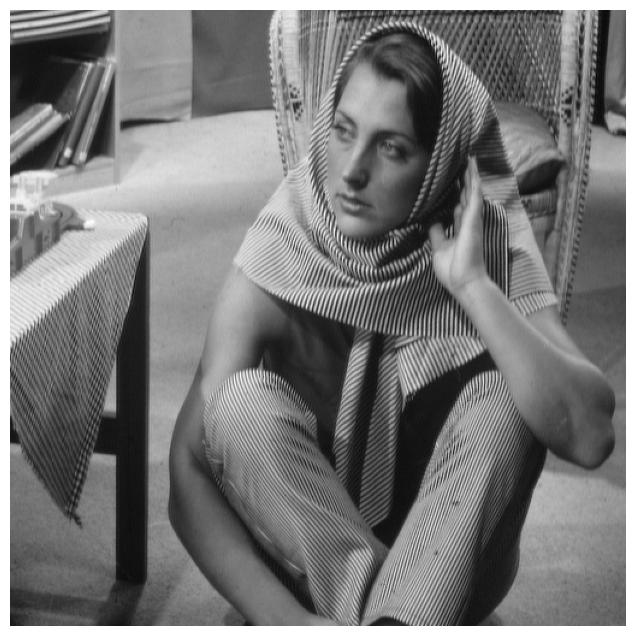

In [2]:
# 4.
image_path = './img/barb.png' 
max_intensity = None
downsampling = None
image = utls.load_and_normalize_image(image_path,device, max_intensity, downsampling)

# Display the image
image_cpu = image.numpy()
fig = plt.figure(figsize=(8, 8))
plt.imshow(image_cpu.squeeze(), cmap='gray')
plt.axis('off') 
plt.show()

In [3]:
# With downsampling=4
%run "mlsp/utils/lab_utils.py"

Image size: torch.Size([128, 128])
Number of observations: 4992


In [4]:
from mlsp.utils.lab_utils import generate_2d_cs_data
# 5.
# Set the seed for reproducibility
seed = 42
torch.manual_seed(seed)
rng = torch.Generator()
rng.manual_seed(seed)
x=image

# Parameters for data generation
percent = 0.6  # This is the fraction of observed pixels in the Fourier domain
isnr = 30  # Input SNR in dB

# Generate the observations y
observations, sensing_operator, sig, clean_observations = generate_2d_cs_data(x, percent, isnr, rng)
y = observations

c:\Program Files\Python39\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Program Files\Python39\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


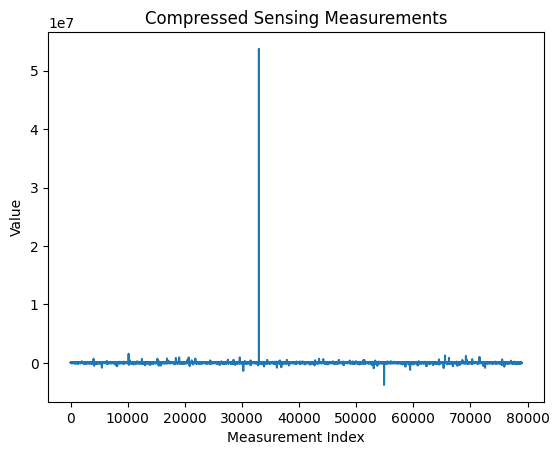

In [5]:
# Convert to numpy for visualization
y_numpy = y.numpy()

plt.plot(y_numpy)
plt.title('Compressed Sensing Measurements')
plt.xlabel('Measurement Index')
plt.ylabel('Value')
plt.show()

> The largest spike is likely the DC component, which represents the average or constant part of the image. The plot is consistent with what one might expect from Fourier domain measurements in a compressed sensing scenario. The key spike and the spread of smaller values across the index range show that we have a mix of high and low-frequency information, as well as the effect of the random sampling mask.

# TV-ADMM regularization

As a baseline, we will consider an ADMM algorithm leveraging a TV regularization of the problem (see tutorial 1), i.e., using $g = \lambda TV(\cdot)$ for $\lambda > 0$.

1. Starting from tutorial 1, complete the [`src/mlsp/model/discrete_gradient.py`](src/mlsp/model/discrete_gradient.py) module to implement the discrete gradient operator and its adjoint. Write a short unit-test to verify the correctness of the implementation of the adjoint operator.

2. Complete the files [`src/mlsp/model/cvx_functions.py`](src/mlsp/model/cvx_functions.py) and [`src/mlsp/model/prox.py`](src/mlsp/model/prox.py) to implement all the building blocks related to the TV regularization involved in the TV-ADMM algorithm.

3. Using tutorial 1, indicate a possible splitting approach to ensure the update steps of the ADMM algorithm are simple to compute. Write the general expression of the resulting update steps.

4. Write a simple [`torch`](https://pytorch.org/docs/stable/index.html) implementation of the ADMM algorithm, either as a function or a class, to solve the optimization problem.

In [6]:
# Q1.
%run "mlsp/model/discrete_gradient.py"

Unit-test-1: Correct implementation of the adjoint of the discrete gradient? True
Unit-test-2: Correct implementation of the adjoint of the discrete gradient? True


In [7]:
# Q2.
%run "./mlsp/model/cvx_functions.py"
%run "./mlsp/model/prox.py"

Correct adjoint implementation? True
TV(x) = 3.705e+01
Correctness proj. non-negativity: True
Correctness proj. l2-ball: True
Grad. tracking for b: False
Grad. tracking for a: True


>  The adjoint implementation of the discrete gradient is correct, as indicated by the result `Correct adjoint implementation? True`.           

> The total variation (TV) of `x` was successfully calculated and returned as `TV(x) = 3.705e+01`.      

> Since `b` is calculated inside a `torch.no_grad()` context, it should not track gradients. In contrast, `a` was created with `requires_grad=True`, so it should track gradients. So the tests in those scripts have passed.

>Q3.          
To apply the ADMM algorithm to the problem of image compressed sensing under TV regularization, a splitting approach is needed that makes the update steps computationally simple. Given the structure of the problem, a common approach is to introduce auxiliary variables to decouple the components of the objective function that are challenging to optimize jointly. Let's consider the problem: 
$$
\min_{\mathbf{x}} \frac{1}{2\sigma^2} \|\mathbf{y} - \mathbf{A x}\|^2 + \lambda\|\mathbf{G}(\mathbf{x})\|_{2,1}
$$
>We can introduce an auxiliary variable $\mathbf{z}$ and reformulate the problem as:
$$
\min_{\mathbf{x}, \mathbf{z}} \frac{1}{2\sigma^2} \|\mathbf{y} - \mathbf{A x}\|^2 + \lambda\|\mathbf{G}(\mathbf{z})\|_{2,1}
$$
>with
$$
\mathbf{x} = \mathbf{z}
$$

Let $f_{\mathbf{y}, \sigma}(\mathbf{x}) = \frac{1}{2\sigma^2} \|\mathbf{y} - \mathbf{A x}\|^2$ and $g_{\lambda}(\mathbf{z}) = \lambda\|\mathbf{G} (\mathbf{z})\|_{2,1}$

>The corresponding scaled augmented Lagrangian is:
$$
\mathcal{L}_\rho(\mathbf{x}, \mathbf{z},\mathbf{u}) = f_{\mathbf{y}, \sigma}(\mathbf{x}) + g_{\lambda}(\mathbf{z}) + \frac{\rho}{2} \|\mathbf{A x} - \mathbf{G}(\mathbf{z}) - \mathbf{y} + \mathbf{u}\|^2
$$
>The ADMM update steps are then as follows:

- **x-update**:
   $$
   \mathbf{x}^{(k+1)} \in \arg \min_{\mathbf{x}} \left\{ f_{\mathbf{y}, \sigma}(\mathbf{x}) + \frac{\rho}{2} \|\mathbf{A x} - \mathbf{G}(\mathbf{z}^{(k)}) - \mathbf{y} + \mathbf{u}^{(k)}\|^2 \right\}
   $$

- **z-update**:
   $$
   \mathbf{z}^{(k+1)} \in \arg \min_{\mathbf{z}} \left\{ g_{\lambda}(\mathbf{z}) + \frac{\rho}{2} \|\mathbf{A x}^{(k+1)} - \mathbf{G}(\mathbf{z}) - \mathbf{y} + \mathbf{u}^{(k)}\|^2 \right\}
   $$

- **u-update**:
   $$
   \mathbf{u}^{(k+1)} = \mathbf{u}^{(k)} + \mathbf{A x}^{(k+1)} - \mathbf{G}(\mathbf{z}^{(k+1)}) - \mathbf{y}
   $$

In [8]:
# Q4.
%run "./mlsp/model/admm.py"

True Coefficients: [ 1.5 -0.8  0.3  0.   0. ]
ADMM Coefficients: [ 1.4944298  -0.88393235  0.2691286  -0.0117204   0.02201768]


# Loading an existing PnP regularization (denoiser)

- This lab will be based on pre-trained regularization available on github. Read the [`README.md`](README.md) file to retrieve the network weights.

- Once retrieved, an example use for one of the networks is provided below.

In [9]:
from mlsp.model.pnp.network_ffdnet import FFDNet
from mlsp.model.pnp.network_unet import UNetRes

rng = torch.Generator(device=device)
rng.manual_seed(1234)

# generating a dummy test image
x0 = torch.normal(0.0, 1.0, (128, 128), generator=rng)

In [13]:
# loading FFDNet network weights (reference: https://github.com/cszn/KAIR/blob/master/main_test_ffdnet.py)
model_path = "./mlsp/weights/ffdnet_gray.pth"
n_channels = 1  # setting for grayscale image
nc = 64  # setting for grayscale image
nb = 15  # setting for grayscale image
denoiser = FFDNet(in_nc=n_channels, out_nc=n_channels, nc=nc, nb=nb, act_mode="R")
denoiser.load_state_dict(torch.load(model_path), strict=True)
denoiser.eval()
denoiser = denoiser.to(device)

# noise level for the denoiser
noise_level_model = 5.0
sigma = torch.full((1, 1, 1, 1), noise_level_model / 255.0).type_as(x0)

In [14]:
# applying the network (applies by defaut to multiple images in a multi-channel setting, Ni x C x Nx x Ny, with Ni = C = 1 in our case)
x_denoised = torch.squeeze(denoiser(x0[None, None, ...], sigma))
x_denoised.shape

torch.Size([128, 128])

# PnP-ADMM

The plug-and-play (PnP) approach relies on the use of a pre-trained denoiser, encoded in this lab by a neural network. We will mostly use pre-trained networks provided [online on github](https://github.com/cszn/KAIR), see example above.

1. Recall the form of the ADMM and PnP-ADMM algorithms instantiated for the problem considered, expressed in terms a generic denoiser $D_\sigma$, with $\sigma > 0$.

2. Write a simple [`torch`](https://pytorch.org/docs/stable/index.html) implementation of the PnP-ADMM algorithm.
> Hint: 
> - make sure the evolution of the cost function is returned to monitor the behaviour of the algorithm.

## Your answers

1. >The corresponding scaled augmented Lagrangian is:
$$
\mathcal{L}_\rho(\mathbf{x}, \mathbf{z},\mathbf{u}) = f_{\mathbf{y}, \sigma}(\mathbf{x}) + g_{\lambda}(\mathbf{z}) + \frac{\rho}{2} \|\mathbf{x} - \mathbf{z} + \mathbf{u}\|^2
$$
>For the considered problem, the ADMM update steps are as follows:

- **x-update**:
   $$
   \mathbf{x}^{(k+1)} \in \arg \min_{\mathbf{x}} \left\{ f_{\mathbf{y}, \sigma}(\mathbf{x}) + \frac{\rho}{2} \|\mathbf{x} - \mathbf{z}^{(k)} + \mathbf{u}^{(k)}\|^2 \right\}
   $$

- **z-update**:
   $$
   \mathbf{z}^{(k+1)} \in \arg \min_{\mathbf{z}} \left\{ g_{\lambda}(\mathbf{z}) + \frac{\rho}{2} \|\mathbf{x}^{(k+1)} - \mathbf{z} + \mathbf{u}^{(k)}\|^2 \right\}
   $$

- **u-update**:
   $$
   \mathbf{u}^{(k+1)} = \mathbf{u}^{(k)} + \mathbf{x}^{(k+1)} - \mathbf{z}^{(k+1)}
   $$

>As for PnP-ADMM, since we get rid of $\mathbf{G}$ using the denoiser $\text{D}_{\sigma}$, $\sigma > 0$, the update steps are as follows:

- **x-update**:
   $$
   \mathbf{x}^{(k+1)} \in \text{prox}_{\rho^{-1} f_{\mathbf{y}, \sigma}} (\mathbf{z}^{(k)} - \mathbf{u}^{(k)})
   $$

- **z-update**:
   $$
   \mathbf{z}^{(k+1)} = \text{D}_{\sigma} (\mathbf{x}^{(k+1)} + \mathbf{u}^{(k)})
   $$

- **u-update**:
   $$
   \mathbf{u}^{(k+1)} = \mathbf{u}^{(k)} + \mathbf{x}^{(k+1)} - \mathbf{z}^{(k+1)}
   $$

In [15]:
# Q2.
%run "./mlsp/model/pnp-admm.py"

Final Result (x): (10, 10, 64, 64)
Final Cost: 13123403.0


# Results and comparisons

1. 
   1. Recall the definition of the reconstruction signal to noise ratio (rSNR). 
   
   2. Which limitation do you see with this criterion when it comes to assessing the reconstruction of low-amplitude coefficients in the unknown parameter? Is this criterion enough to fully assess the performance of an algorithm.
   
   3. Implement a `torch` function to compte the rSNR.

2. Visually compare the results obtained with the TV-ADMM and PnP-ADMM algorithms, as well as the evolution of the cost function over the iterations.

3. Evaluate the reconstruction performance in terms of rSNR and structural similarity index ([SSIM](https://scikit-image.org/docs/stable/auto_examples/transform/plot_ssim.html))

4. Conclude on the performance of these approaches. Identify some of their limits.

## Your answers

1. 
   1. The Reconstruction Signal-to-Noise Ratio (rSNR) is a measure used in signal processing and image reconstruction to quantify the quality of the reconstructed signal compared to the original signal, taking into account the presence of noise. It is often expressed in decibels (dB), with $\mathbf{x}$ the original signal, and $\mathbf{\hat{x}}$ the reconstructed signal as follows:
   $$
      \text{rSNR}(\mathbf{\hat{x}}, \mathbf{x}) = 10 \log_{10} \left( \frac{\|\mathbf{x}\|^2}{\|\mathbf{\hat{x}} - \mathbf{x}\|^2} \right)
   $$

   2. The rSNR is highly sensitive to the presence of noise. In situations where the signal has low-amplitude coefficients, the impact of noise on the rSNR can be significant. Small changes in the reconstructed signal due to noise can lead to a substantial reduction in the rSNR, even if the reconstruction captures the low-amplitude components reasonably well.

      To comprehensively evaluate the performance of an algorithm, it is advisable to consider other metrics and criteria, such as perceptual quality metrics like Structural Similarity Index Measure (SSIM),  Peak Signal-to-Noise Ratio (PSNR) or Mean Squared Error (MSE).

In [16]:
# Q 1.3

def compute_rSNR(original_signal, reconstructed_signal):
    """
    Computes the Reconstruction Signal-to-Noise Ratio (rSNR) using PyTorch.

    Parameters:
    - original_signal (torch.Tensor): The original signal.
    - reconstructed_signal (torch.Tensor): The reconstructed signal.

    Returns:
    - rSNR (float): The computed rSNR value in decibels (dB).
    """

    # Ensure the inputs have the same shape
    assert original_signal.shape == reconstructed_signal.shape

    # Calculate the power of the original signal
    power_original = torch.sum(original_signal ** 2)

    # Calculate the power of the residual noise
    residual_noise = reconstructed_signal - original_signal
    power_noise = torch.sum(residual_noise ** 2)

    # Avoid division by zero
    if power_noise == 0:
        return float('inf')

    # Calculate rSNR in decibels
    rSNR = 10 * torch.log10(power_original / power_noise)

    return rSNR.item()

In [ ]:
# Q2.
# Q3.
# Q4.

# Bonus: implementation using the `deepinv` library

The [`deepinv`](https://github.com/deepinv/deepinv) library offers a pre-defined set of algorithms and modeling blocks to solve inverse problems with PnP priors.

1. Take a look at the [documentation](https://deepinv.github.io/deepinv/index.html) and the [provided examples](https://deepinv.github.io/deepinv/auto_examples/plug-and-play/demo_PnP_DPIR_deblur.html#sphx-glr-auto-examples-plug-and-play-demo-pnp-dpir-deblur-py). Use one of the optimization algorithms available in the library for comparison with the PnP-ADMM algorithm implemented above.

2. Compare the results obtained to those of your implementation in terms of reconstruction performance and timing.

> Hints:
> - Take a look at the [tutorial example](https://deepinv.github.io/deepinv/auto_examples/plug-and-play/demo_PnP_custom_optim.html#sphx-glr-auto-examples-plug-and-play-demo-pnp-custom-optim-py) to see how to combine the different ingredients made available in the library.

In [ ]:
# your code (mostly call to functions you need to implement in a Python module)